# RUN on Colab
# Import Libraries and Mount GDrive

In [1]:
%matplotlib inline
import csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time as time
import math
import os

from PIL import ImageDraw
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Import Raccoons Images
Only do it once

In [4]:
%cd /content/drive/My Drive/_HTX/Raccoon_Project

# ! git clone https://github.com/experiencor/raccoon_dataset.git/

/content/drive/My Drive/_HTX/Raccoon_Project


# View Images

In [5]:
for i in range(5,7):
  image = Image.open(f"raccoon_dataset/images/test_train_dev/raccoon-{i}.jpg")
  plt.imshow(image)
  plt.axis('off')
  plt.show()

FileNotFoundError: ignored

# Check Annotations for a single image
For image #6

In [ ]:
# Coords from XML file
xmin = 1   # Top left
ymin = 44

xmax = 307  # Bottom Right
ymax = 316

draw = ImageDraw.Draw(image)
draw.rectangle([(xmin, ymin), (xmax, ymax)], outline = "red", width=4)
draw.text(((xmin+xmax)/2, ymin-20), "Raccoon")
image

# Import ALL labels into pd df

**code to real separate xml files**

CSV harder to us for multiple class? 


In [ ]:
labels = pd.read_csv("raccoon_dataset/data/raccoon_labels.csv")
labels.head()
# labels.tail()

# Import torchvision libraries

In [ ]:
# Change directory to object detection dir
%cd racoon_obj_detection

# ! git clone https://github.com/pytorch/vision.git

In [ ]:
# Copy some py files for importing later

from shutil import copy
copy("vision/references/detection/utils.py", "vision")
copy("vision/references/detection/transforms.py", "vision")
copy("vision/references/detection/coco_eval.py", "vision")
copy("vision/references/detection/engine.py", "vision")
copy("vision/references/detection/coco_utils.py", "vision")

In [ ]:
!pwd

# Using Faster R-CNN model pre-trained on COCO
Options:

Faster R-CNN ResNet-50 FPN

Mask R-CNN ResNet-50 FPN


In [ ]:
import torch
import torchvision
import torch.utils.data

# Import selected model - Faster R-CNN ResNet-50 FPN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Mask R-CNN ResNet-50 FPN - KIV for now!
# from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

%cd vision

from engine import train_one_epoch, evaluate

import utils
import transforms as T   # For flipping images etc

%cd /content/drive/My Drive/_HTX/Raccoon_Project/racoon_obj_detection

In [ ]:
!pwd

# Extract data labels

In [ ]:
# Function to extract data labels
# "labels" from previously read pandas df of csv file

def parse_one_annot(path_to_data_file, filename):
  target_row = labels[labels["filename"] == filename]                 # Extracts one row matching "filename"
  boxes_array = target_row[["xmin", "ymin", "xmax", "ymax"]].values   # Extracts bounding coords from that row
   
  return boxes_array

In [ ]:
# BREAKING DOWN ABOVE CODE

# labels from previously read pandas df of csv file
# Extracts row matching "target_filename"
target_filename = "raccoon-1.jpg"
target_row = labels[labels["filename"] == target_filename]
target_row

In [ ]:
# Get values from target row
test_box = target_row[["xmin", "ymin", "xmax", "ymax"]].values
test_box

# Set up Dataset Class
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

ataset should inherit from the standard torch.utils.data.

Dataset class, and implement _ _ len _ _ and _ _ getitem _ _


"_ _ getitem _ _" should return:



1. PIL Image of size (Height, Width)
2. target: a dict with the following fields:
    * __boxes__ (FloatTensor[N, 4]): coordinates of the N bounding boxes in [x0, y0, x1, y1] format
    * __labels__ (Int64Tensor[N]): label (e.g. raccoon) for each bounding box. 0 represents always the background class.
    * __image_id__ (Int64Tensor[1]): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * __area__ (Tensor[N]):  area of the bounding box. Used to separare small/medium/large boxes in mAP
    * __iscrowd__(UInt8Tensor[N]) - 8-bit integer (unsigned): instances with iscrowd=True will be ignored during evaluation




In [ ]:
class RaccoonDataset(torch.utils.data.Dataset):
  # Transforms is for data augmentation, by default None but a transforms helper fn is used (see below)
  
  def __init__(self, root, data_file, transforms=None):
    self.root = root
    self.transforms = transforms
    self.imgs = sorted(os.listdir(os.path.join(root, "images")))      # Navigate to raccoon_dataset/images
    self.path_to_data_file = data_file


  # Get image information, returning required tensor "target"
  def __getitem__(self, idx):

    # PART 0: GET IMAGE PIL FILE
    # load EACH image and its bounding boxes
    img_path = os.path.join(self.root, "images", self.imgs[idx])        # Get address of each image
    img = Image.open(img_path).convert("RGB")                           # Open image and convert to RGB
  
    # PART 1: GET COORDS OF BOUNDING BOXES   
    box_list = parse_one_annot(self.path_to_data_file,                  # Get bounding box coords for this image
    self.imgs[idx])
    boxes = torch.as_tensor(box_list, dtype=torch.float32)              # Convert array of coords to tensor

    # PART 2: GET CLASS LABELS
    # num_objs = 4 coordinate values
    num_objs = len(box_list)
    # *** there is only one class ***
    labels = torch.ones((num_objs,), dtype=torch.int64)             # Maybe able to vary for muti-class datasets

    # PART 3: GET IMAGE_IDs
    image_id = torch.tensor([idx])

    # PART 4: COMPUTE AREA
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,0])

    # PART 5: suppose all instances are not crowd so none will be ignored
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    # ASSEMBLE REQUIRED TARGET DICTIONARY
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd


    if self.transforms is not None:
        img, target = self.transforms(img, target)
    return img, target


  def __len__(self):
    return len(self.imgs)

In [ ]:
# Testing if the above works - should return tuple with 1. PIL image 2. target dict

# Define dataset (images) and labels location
dataset = RaccoonDataset(root= "/content/drive/My Drive/_HTX/Raccoon_Project/raccoon_dataset", 
                        data_file= "raccoon_dataset/data/raccoon_labels.csv")

# Test if successful
dataset.__getitem__(2)

(<PIL.Image.Image image mode=RGB size=650x417 at 0x7F5E81517910>,
 {'area': tensor([141120.]),
  'boxes': tensor([[ 81.,  88., 522., 408.]]),
  'image_id': tensor([0]),
  'iscrowd': tensor([0]),
  'labels': tensor([1])})

# Set up Faster R-CNN ResNet50 FPN Model
Transfer Learning via finetunning from pretrained model on COCO

In [ ]:
# Set up model with required no. of classes

def get_model(num_classes):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

  # get the number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features

  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  return model

# Data Augmentation to broaden dataset


*   Horizontal flip



In [ ]:
def horz_transform(train):
    # Create new list of original and transformed images
    transforms = []

    # converts the PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())

    # Augments image only if during training stage; train == True:
    if train:
      # Randomly flip the training images and ground-truths for data augmentation
      transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# Main Training Function

In [ ]:
# Determine number of subprocesses for dataloader
# 2 is recommended, but 4 still works. Too high may cause slow-down
num_workers = 2

# Get training dataset
dataset = RaccoonDataset(root= "/content/drive/My Drive/_HTX/Raccoon_Project/raccoon_dataset", 
                        data_file= "raccoon_dataset/data/raccoon_labels.csv", 
                        transforms = horz_transform(train=True))


# Get testing dataset - same as that for training BUT no augmentation. 
# TODO: Experiment with a different dataset
dataset_test = RaccoonDataset(root= "/content/drive/My Drive/_HTX/Raccoon_Project/raccoon_dataset", 
                        data_file= "raccoon_dataset/data/raccoon_labels.csv", 
                        transforms = horz_transform(train=False))

# Split the dataset into train and test set
torch.manual_seed(1006)     # Set my own seed for random number generation for consistency

# Randomly mix up numbers from 1 to length of dataset
indices = torch.randperm(len(dataset)).tolist()

# Try to preserve distribution of positive and negative in classification problems
# but for obj det permutating data is fine

# NEGATIVE images - datasets without the class in it
# Then taking random indcies will have to maintian distribution of +ve and -ve

# Take all but last 40 datapoints for training. Last 40 for testing
dataset = torch.utils.data.Subset(dataset, indices[:-40])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-40:])


# Define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
              dataset, batch_size=2, shuffle=True, num_workers=num_workers, 
              collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
                  dataset_test, batch_size=1, shuffle=False, num_workers=num_workers,
                  collate_fn=utils.collate_fn)

print(f"We have: {len(indices)} examples, {len(dataset)} are training and {len(dataset_test)} testing")

We have: 200 examples, 160 are training and 40 testing


# Set up Model - Currently training in GPU

In [ ]:
# Check if GPU available and train on GPU
print(torch.cuda.is_available())
device = torch.device('cuda')
# device = torch.device('cpu')

True


In [ ]:
# 2-classes - is Raccoon and Background
num_classes = 2

# Learning Rate & Step Size for lr scheduler
lr = 0.005
stp = 3   # Decreases learning rate every 3 epochs
gma = 0.1 # Gamma - 0.1 means decrease lr by 10x

### TODO: ****** Hyperparameter tuning is to figure out the optimal lr, stp, gma ******

# get the model using our helper function
model = get_model(num_classes)

# move model to the CUDA device - NEED TO BE DONE BEFORE CONSTRUCTING OPTIMIZERS (torch.optim)
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=lr,
                            momentum=0.9, weight_decay=0.0005)


# Learning Rate Scheduler: decreases the learning rate by 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=stp,
                                               gamma=gma)

#TODO find loss fn for R-CNN

# Import Tensorboard to log training (running below)

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Doing the actual training

In [ ]:
num_epochs = 15

# Frequency of displaying results (NOT BATCH SIZE!)
printing_freq = 10

for epoch in range(num_epochs):

  # train for one epoch, printing every 10 iterations
  # Return loss etc. data from "train_one_epoch" fn in engine.py
  metric_logger = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=printing_freq)

  # update the learning rate
  lr_scheduler.step()

  # evaluate on the TEST dataset
  coco_eval = evaluate(model, data_loader_test, device=device)


  # PLOT PERFORMANCE DATA TO TENSORBOARD
  # PART 1: LOSS AND LEARNING RATE
  metrics = metric_logger.__dict__['meters']
  # learn_rate = metrics['lr']
  median_loss = np.median(metrics['loss'].__dict__['deque'])
  median_loss_classifier = np.median(metrics['loss_classifier'].__dict__['deque'])
  median_loss_box_reg = np.median(metrics['loss_box_reg'].__dict__['deque'])
  # writer.add_scalar("Learn Rate", learn_rate, epoch)
  writer.add_scalars('Losses',{'Loss': median_loss, 'Loss Classifier':median_loss_classifier, 'Loss (Box_Reg)': median_loss_box_reg}, epoch)


  # PART 2: mAPs and RPs
  coco_output_stats = coco_eval.coco_eval['bbox'].__dict__['stats']
  writer.add_scalars('Average Precision (AP), ALL Area, IOU vary',{'IOU=0.5 to 0.95': coco_output_stats[0], 'IOU=0.50':coco_output_stats[1], 'IOU=0.75': coco_output_stats[2]}, epoch)
  writer.add_scalars('Average Precision (AP), IOU=0.5 to 0.95, Area vary',{'Small Area': coco_output_stats[3], 'Medium Area':coco_output_stats[4], 'Large Area': coco_output_stats[5]}, epoch)
  writer.add_scalars('Average Recall (AR), ALL Area, IOU vary',{'IOU=0.5 to 0.95': coco_output_stats[6], 'IOU=0.50':coco_output_stats[7], 'IOU=0.75': coco_output_stats[8]}, epoch)
  writer.add_scalars('Average Recall (AR), IOU=0.5 to 0.95, Area vary',{'Small Area': coco_output_stats[9], 'Medium Area':coco_output_stats[10], 'Large Area': coco_output_stats[11]}, epoch)


  # TODO: Find worked example of computing AP

Epoch: [0]  [ 0/80]  eta: 0:01:09  lr: 0.000068  loss: 0.0484 (0.0484)  loss_classifier: 0.0131 (0.0131)  loss_box_reg: 0.0231 (0.0231)  loss_objectness: 0.0011 (0.0011)  loss_rpn_box_reg: 0.0110 (0.0110)  time: 0.8653  data: 0.1309  max mem: 4026
Epoch: [0]  [10/80]  eta: 0:00:41  lr: 0.000701  loss: 0.0533 (0.0567)  loss_classifier: 0.0135 (0.0166)  loss_box_reg: 0.0310 (0.0291)  loss_objectness: 0.0011 (0.0013)  loss_rpn_box_reg: 0.0066 (0.0097)  time: 0.5966  data: 0.0181  max mem: 4026
Epoch: [0]  [20/80]  eta: 0:00:33  lr: 0.001333  loss: 0.0530 (0.0573)  loss_classifier: 0.0135 (0.0169)  loss_box_reg: 0.0310 (0.0305)  loss_objectness: 0.0004 (0.0009)  loss_rpn_box_reg: 0.0066 (0.0090)  time: 0.5493  data: 0.0071  max mem: 4026
Epoch: [0]  [30/80]  eta: 0:00:27  lr: 0.001965  loss: 0.0514 (0.0570)  loss_classifier: 0.0131 (0.0161)  loss_box_reg: 0.0299 (0.0314)  loss_objectness: 0.0003 (0.0012)  loss_rpn_box_reg: 0.0055 (0.0082)  time: 0.5203  data: 0.0074  max mem: 4026
Epoch: [

In [ ]:
# TESTING ONLY

# METRIC LOGGER
# print(type(metric_logger))
# print(metric_logger.__dict__)
# print(metric_logger.__dict__['meters']['lr'])
# print(metric_logger.__dict__['meters']['loss'])
# deq = metric_logger.__dict__['meters']['loss'].__dict__['deque']
# print(deq)
# print(np.median(deq))

# # Extract info from metric logger
# metrics = metric_logger.__dict__['meters']
# learn_rate = metrics['lr']
# median_loss = np.median(metrics['loss'].__dict__['deque'])
# median_loss_classifier = np.median(metrics['loss_classifier'].__dict__['deque'])
# median_loss_box_reg = np.median(metrics['loss_box_reg'].__dict__['deque'])
# median_loss_objectness = np.median(metrics['loss_objectness'].__dict__['deque'])

# print(median_loss, median_loss_classifier, median_loss_box_reg, median_loss_objectness)

Ouput array provides mAPs in the following order (image below)

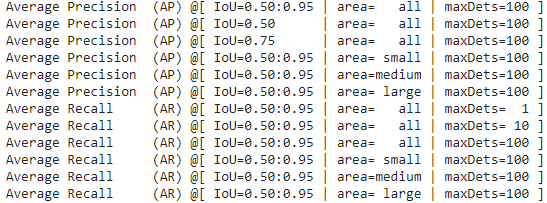

In [ ]:
# # TESTING ONLY

# # COCO_EVAL - this gives all mAPs
# coco_output_stats = coco_eval.coco_eval['bbox'].__dict__['stats']

# AP_50_95IOU_allarea = coco_output_stats[0]
# AP_50IOU_allarea = coco_output_stats[1]
# AP_75IOU_allarea = coco_output_stats[2]

# AP_50_95IOU_smallarea = coco_output_stats[3]
# AP_50_95IOU_medarea = coco_output_stats[4]
# AP_50_95IOU_largearea = coco_output_stats[5]

# AR_50_95IOU_allarea = coco_output_stats[6]
# AR_50IOU_allarea = coco_output_stats[7]
# AR_75IOU_allarea = coco_output_stats[8]

# AR_50_95IOU_smallarea = coco_output_stats[9]
# AR_50_95IOU_medarea = coco_output_stats[10]
# AR_50_95IOU_largearea = coco_output_stats[11]

# See results using Tensorboard

In [ ]:
# Data Found under racoon_obj_detection > runs

%tensorboard --logdir runs/Jun03_08-19-26_5e378df186cf

# !tensorboard --logdir=runs

# Save the model

In [ ]:
# os.mkdir("<your path>/pytorch object detection/raccoon/")

torch.save(model.state_dict(), "/content/drive/My Drive/_HTX/Raccoon_Project/raccoon_models/model")

# Make Prediction with model

In [ ]:
# Load Model 
loaded_model = get_model(num_classes = 2)
loaded_model.load_state_dict(torch.load("/content/drive/My Drive/_HTX/Raccoon_Project/raccoon_models/model"))

<All keys matched successfully>

# Draw outputs - SEEN data (test dataset)
**Green = Ground Truth**

**Red = Predicted**

In [ ]:
# Function to draw image

def draw_outputs_seen_data(idx):
  # Underscore "_" is used as the 2nd output (target dict) is not important. Only want "img"
  img, _ = dataset_test[idx]

  # Retrieve torch.tensor containing box coordinate(s) and convert to np.array
  # NOTE: Can have multiple label boxes! GROUND TRUTH BOXES
  label_boxes = np.array(dataset_test[idx][1]["boxes"])


  # Put the model in evaluation mode
  loaded_model.eval()


  # Retrieve predicted bounding box (red)
  # There are MANY predicted bounding boxes, each with a score
  with torch.no_grad():
    prediction = loaded_model([img])


  # Get image and prepare to print image
  image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
  draw = ImageDraw.Draw(image)


  # DRAWING BOUNDING BOXES

  # Draw groundtruth (GREEN)
  for elem in range(len(label_boxes)):
    draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
    (label_boxes[elem][2], label_boxes[elem][3])], 
    outline ="green", width =3)

  # Draw predicted bounding box (RED)
  for element in range(len(prediction[0]["boxes"])):

    # Coords of predicted bouding box. Replaced .cpu() with .detach() for performance
    boxes = prediction[0]["boxes"][element].detach().numpy()

    # Score = confidence level of prediction 
    score = np.round(prediction[0]["scores"][element].detach().numpy(),
                      decimals= 4)
    
    # Only draw predicted bounding boxes exceeding 80% CONF
    if score > 0.8:
      draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
      outline ="red", width =3)
      draw.text((boxes[0], boxes[1]), text = str(score))

  
  # Print scoring details
  print(f"Prediction scores are: ")
  print(prediction[0]["scores"].detach().numpy())

  # Show image
  plt.figure(figsize=(12, 8))
  plt.title(f"Img #{idx} of test")
  plt.imshow(image)
  plt.axis('off')


  # TODO: Expect low probabilities 0.0X for non-racoon stuff. Bigger dataset?
  # TODO: 

Prediction scores are: 
[0.9830246 0.9707482]
Prediction scores are: 
[0.9941831]


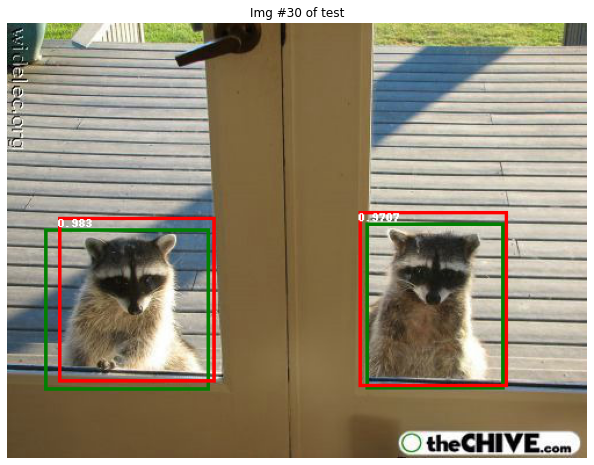

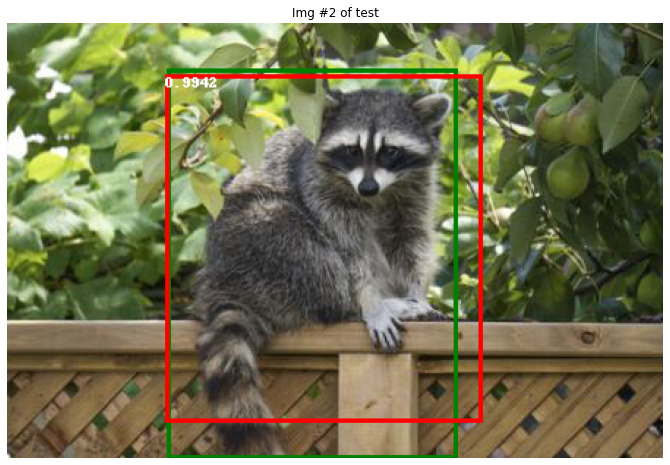

In [ ]:
# Draw images (Change ID to see another image from test dataset)

draw_outputs_seen_data(30)
draw_outputs_seen_data(2)

# Draw Outputs - UNSEEN data

In [ ]:
# Function to draw image

def draw_outputs_unseen_data(img_path):

  # Convert unseen image into tensor
  img = Image.open(img_path).convert("RGB")
  transforms = horz_transform(train=True)
  target = None
  img, target = transforms(img, target)


  # Put the model in evaluation mode
  loaded_model.eval()

  # Retrieve predicted bounding box (red)
  # There are MANY predicted bounding boxes, each with a score
  with torch.no_grad():
    prediction = loaded_model([img])


  # Get image and prepare to print image
  image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
  draw = ImageDraw.Draw(image)
  plt.figure(figsize=(12, 8))


  # DRAWING BOUNDING BOXES

  # Draw predicted bounding box (RED)
  if max(prediction[0]["scores"].detach().numpy()) <= 0.9:
    plt.title("I don't think there is a raccoon in this image!")
  
  else: 
    for element in range(len(prediction[0]["boxes"])):

      # Coords of predicted bouding box. Replaced .cpu() with .detach() for performance
      boxes = prediction[0]["boxes"][element].detach().numpy()

      # Score = confidence level of prediction 
      score = np.round(prediction[0]["scores"][element].detach().numpy(),
                        decimals= 4)
      
      # Only draw predicted bounding boxes
      draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
      outline ="red", width =3)
      draw.text((boxes[0], boxes[1]), text = str(score))

    plt.title("Raccoon found!!")

  
  # Print scoring details
  print(f"Prediction scores are: ")
  print(prediction[0]["scores"].detach().numpy())

  # Show image
  plt.imshow(image)
  plt.axis('off')

Prediction scores are: 
[0.5513592]
Prediction scores are: 
[0.964011   0.25009015 0.14841911 0.08603647]
Prediction scores are: 
[0.9848357]
Prediction scores are: 
[0.56227165 0.3412124  0.3412124  0.3412124  0.15207185 0.14562884]


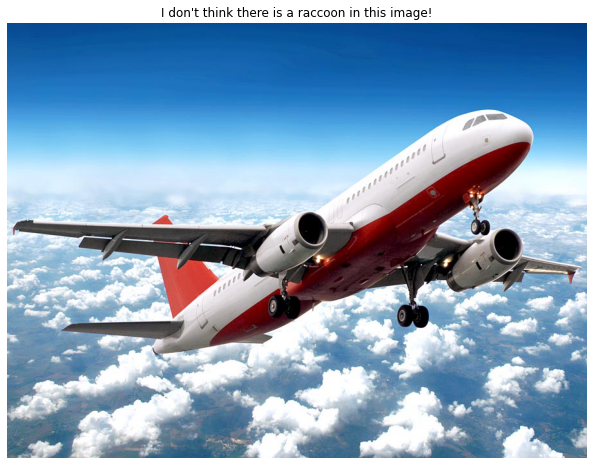

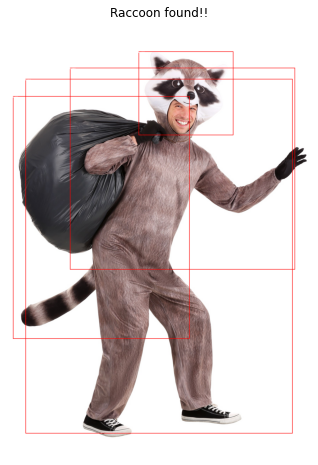

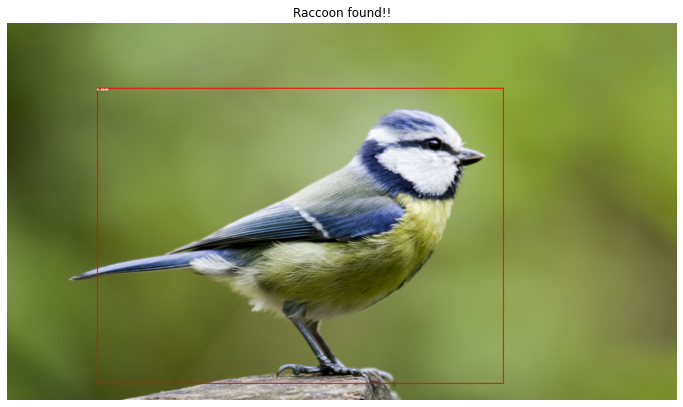

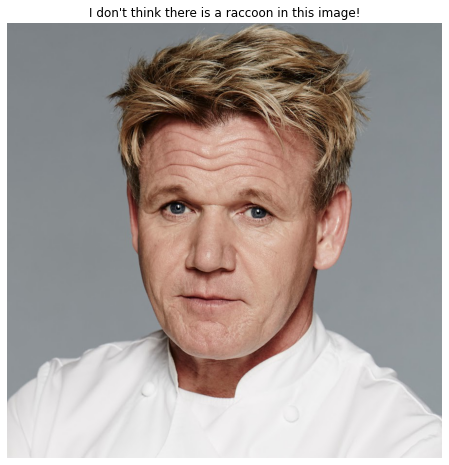

In [ ]:
# Try with foreign image

img_path = "/content/drive/My Drive/_HTX/Raccoon_Project/Non_raccoon_imgs/not_raccoon_3.jpg"
draw_outputs_unseen_data(img_path)

img_path = "/content/drive/My Drive/_HTX/Raccoon_Project/Non_raccoon_imgs/not_raccoon_1.jpg"
draw_outputs_unseen_data(img_path)

img_path = "/content/drive/My Drive/_HTX/Raccoon_Project/Non_raccoon_imgs/not_raccoon_2.jpg"
draw_outputs_unseen_data(img_path)

img_path = "/content/drive/My Drive/_HTX/Raccoon_Project/Non_raccoon_imgs/not_raccoon_4.jpg"
draw_outputs_unseen_data(img_path)